In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

ratings = pd.read_csv("ml-25m/ratings.csv")
ratings.info()

movies = pd.read_csv("ml-25m/movies.csv")
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In this phase, we'll explore the dataset to understand its structure, find potential biases, and identify challenges we'll need to address.

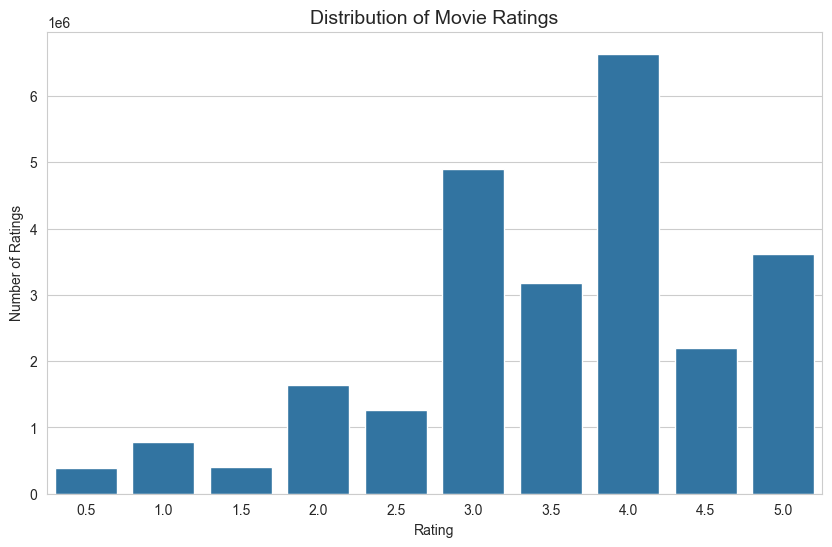

In [27]:
# Get info regarding distribution of ratings, note that people often tend to rate movies they like, thus the skew left nature of the graph 

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

sns.countplot(x='rating', data=ratings)

plt.title('Distribution of Movie Ratings', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

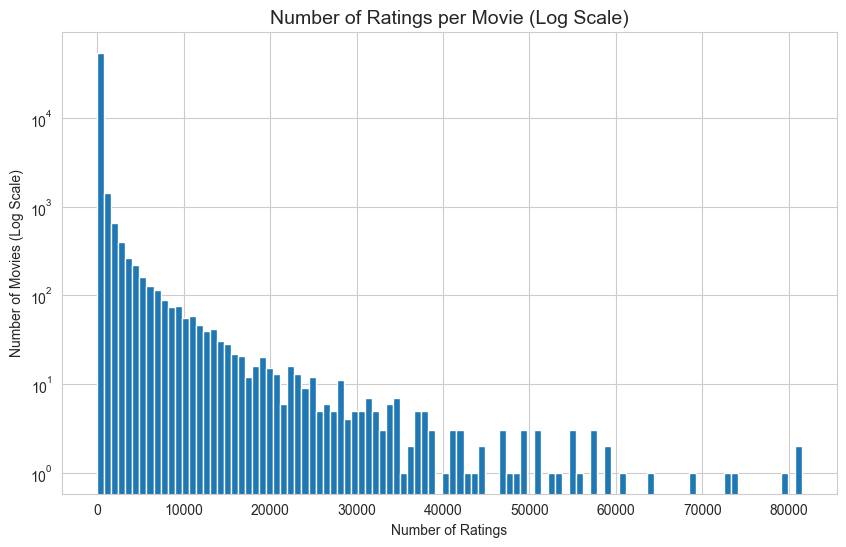

--- Top 10 Most Rated Movies ---
             0                                      title  \
movieId                                                     
356      81491                        Forrest Gump (1994)   
318      81482           Shawshank Redemption, The (1994)   
296      79672                        Pulp Fiction (1994)   
593      74127           Silence of the Lambs, The (1991)   
2571     72674                         Matrix, The (1999)   
260      68717  Star Wars: Episode IV - A New Hope (1977)   
480      64144                       Jurassic Park (1993)   
527      60411                    Schindler's List (1993)   
110      59184                          Braveheart (1995)   
2959     58773                          Fight Club (1999)   

                                   genres  
movieId                                    
356              Comedy|Drama|Romance|War  
318                           Crime|Drama  
296           Comedy|Crime|Drama|Thriller  
593           

In [28]:
# Calculate ratings per movie. A small number of movies (like Forrest Gump, Shawshank Redemption) 
# have tens of thousands of ratings, while thousands of movies have only a handful
movie_ratings_count = ratings.groupby('movieId').size().sort_values(ascending=False)
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(movie_ratings_count, bins=100, log=True) # Use a log scale to see the distribution better
plt.title('Number of Ratings per Movie (Log Scale)', fontsize=14)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies (Log Scale)')
plt.show()
print("--- Top 10 Most Rated Movies ---")
# Merge with movie titles to see the names
top_movies = movie_ratings_count.head(10).to_frame().join(movies.set_index('movieId'))
print(top_movies)

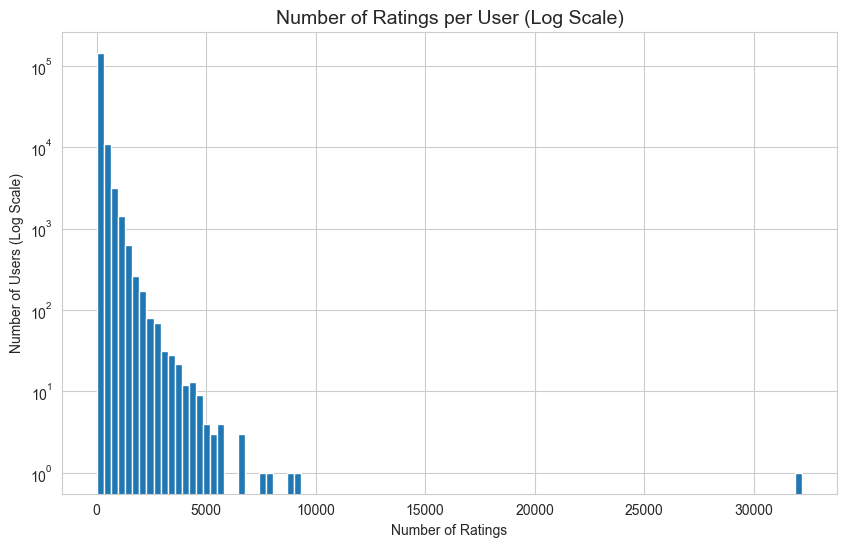

Minimum ratings per user: 20
Median ratings per user: 71.0


In [29]:
# Calculate ratings per user. Every user has rated atleast 20 movies
user_ratings_count = ratings.groupby('userId').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=100, log=True)
plt.title('Number of Ratings per User (Log Scale)', fontsize=14)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (Log Scale)')
plt.show()
print(f"Minimum ratings per user: {user_ratings_count.min()}")
print(f"Median ratings per user: {user_ratings_count.median()}")

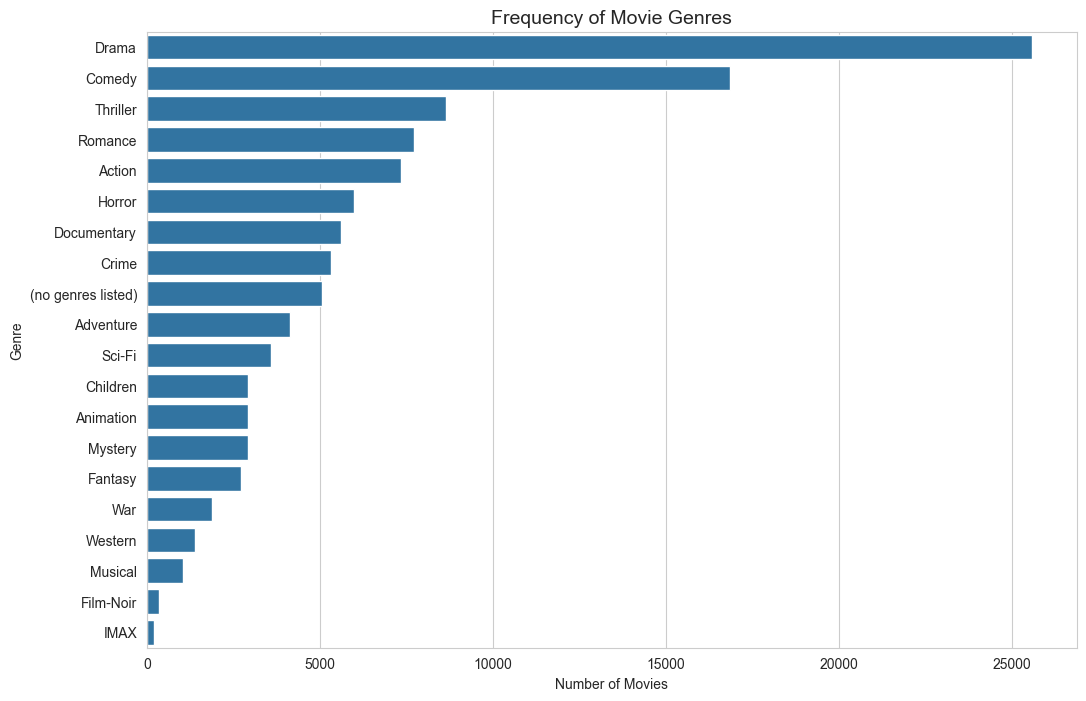

In [30]:
# Determine quantity of genres. Drama and Comedy are most prevelant
genres_df = movies['genres'].str.get_dummies(sep='|')
genre_counts = genres_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h')
plt.title('Frequency of Movie Genres', fontsize=14)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

Here, we'll combine our data and transform it into the user-item interaction matrix that our models will use.

In [31]:
df = pd.merge(ratings, movies, how='left', on='movieId')
print("--- Merged DataFrame ---")
print(df.head())

--- Merged DataFrame ---
   userId  movieId  rating   timestamp  \
0       1      296     5.0  1147880044   
1       1      306     3.5  1147868817   
2       1      307     5.0  1147868828   
3       1      665     5.0  1147878820   
4       1      899     3.5  1147868510   

                                              title  \
0                               Pulp Fiction (1994)   
1  Three Colors: Red (Trois couleurs: Rouge) (1994)   
2  Three Colors: Blue (Trois couleurs: Bleu) (1993)   
3                                Underground (1995)   
4                        Singin' in the Rain (1952)   

                        genres  
0  Comedy|Crime|Drama|Thriller  
1                        Drama  
2                        Drama  
3             Comedy|Drama|War  
4       Comedy|Musical|Romance  


In [32]:

# Now we need to pivot our dataframe. Currently, it is very long, as each row is a unique rating. Instead, 
# each row will be a user, and the columns will be the movie tiles and the user's respective ratings
# this will end up being sparse, which will be addressed later


# For performance, work with a smaller sample of the data first.
# This makes pivoting much faster as we're learning.
df_sample = df.sample(n=100000, random_state=42)

user_item_matrix = df_sample.pivot_table(index='userId', columns='title', values='rating')

print("--- User-Item Matrix ---")
print(f"Shape of the matrix: {user_item_matrix.shape}")
print(user_item_matrix.head())


--- User-Item Matrix ---
Shape of the matrix: (55057, 10260)
title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   
7              NaN                                      NaN   

title   'Round Midnight (1986)  'Til There Was You (1997)  'burbs, The (1989)  \
userId                                                                          
1                          NaN                        NaN                 NaN   
3                          NaN                        NaN                 NaN   
4                          NaN                        NaN                 NaN   
5                          NaN                        NaN                 NaN   
7          

In [33]:
# We'll fill missing NaN ratings with 0 for now
user_item_matrix_filled = user_item_matrix.fillna(0)

print("\n--- Filled User-Item Matrix ---")
display(user_item_matrix_filled.head())


--- Filled User-Item Matrix ---


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),Υπάρχει Και Φιλότιμο (1965),Он вам не Димон (2017)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To get the baseline model, im going to implement a Collaborative Filtering model, basically a model that recommends movies to users based off of the preferences of similar users within the dataset. 

To do this, I'm going to use Matrix Factorization and Singular Value Decomposition.
Matrix Factorization Notes:

    We have a matrix, where the rows are users and the columns are the movies, with the values being the ratings. We need a way to predict the rating a user might give a movie they havent seen before. We do this by understanding the dependencies within the matrix. For example, two users who have similar tastes in movies will likely rate movies in similar ways. We need a way to understand and use all these dependences in the matrix, which comes from matrix factorization.
    
    At a high level, all matrix factorization does is split our large matrix into two smaller, dense matrices, where their product yields our original matrix. The columns in these new matrix are our categories/factors like a genre or other characteristic, in this case of the movie. There are many methods of figuring out how to weight each of these.

    Gradient Descent: Take the dot product, for this it would be for each user at each movie. If the product is too low, raise the respective weights, and vice versa for too high. This requires an error function to quantify how badly the proposed answer or rating was from the actual rating. One example would be to take the sum of the square of the differences between the proposed and actual values, and then reduce this error. This is where gradient descent comes in.

In [34]:
# First need to create continuous indices for out embedding layers
user_mapping = {id: i for i, id in enumerate(df_sample['userId'].unique())}
movie_mapping = {id: i for i, id in enumerate(df_sample['movieId'].unique())}

df_sample['user_idx'] = df_sample['userId'].map(user_mapping)
df_sample['movie_idx'] = df_sample['movieId'].map(movie_mapping)

print("--- Data with continuous indices ---")
display(df_sample.head())

--- Data with continuous indices ---


,userId,movieId,rating,timestamp,title,genres,user_idx,movie_idx
15347762,99476,104374,3.5,1467897440,About Time (2013),Drama|Fantasy|Romance,0,0
16647840,107979,2634,4.0,994007728,"Mummy, The (1959)",Horror,1,1
23915192,155372,1614,3.0,1097887531,In & Out (1997),Comedy,2,2
10052313,65225,7153,4.0,1201382275,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,3,3
12214125,79161,500,5.0,1488915363,Mrs. Doubtfire (1993),Comedy|Drama,4,4


In [35]:
# Now we need to create a PyTorch Dataset to define how our data will be grouped

class MovieRatingDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Now we prepare the data for the DataLoader
   
# Extract columns as numpy arrays
X = df_sample[['user_idx', 'movie_idx']].values
y = df_sample['rating'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Datasets
train_dataset = MovieRatingDataset(
    torch.LongTensor(X_train[:, 0]),
    torch.LongTensor(X_train[:, 1]),
    torch.FloatTensor(y_train)
)

val_dataset = MovieRatingDataset(
    torch.LongTensor(X_val[:, 0]),
    torch.LongTensor(X_val[:, 1]),
    torch.FloatTensor(y_val)
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

print(f"\nDataLoaders created. Number of training batches: {len(train_loader)}")


DataLoaders created. Number of training batches: 79


In [36]:
# Now we can define our model

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50):
        super(MatrixFactorization, self).__init__()
        
        # User embedding layer. Essentially creates our table of num_users rows and embedding_dim columns, where each column is a 'taste'
        # a user has.
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_dim)
        
        # Movie embedding layer. Same as above
        self.movie_embedding = nn.Embedding(num_embeddings=num_movies, embedding_dim=embedding_dim)
        
    def forward(self, user_indices, movie_indices):

        # Get the embedding vectors for the users and movies in the current batch
        user_vector = self.user_embedding(user_indices)
        movie_vector = self.movie_embedding(movie_indices)
        
        # Take the dot product of user and movie vectors
        # (batch_size, embedding_dim) * (batch_size, embedding_dim) -> sum along dim 1 -> (batch_size)
        dot_product = (user_vector * movie_vector).sum(dim=1)
        
        return dot_product

# --- Get number of unique users and movies ---
num_users = len(user_mapping)
num_movies = len(movie_mapping)

print(f"Number of unique users: {num_users}")
print(f"Number of unique movies: {num_movies}")

# --- Instantiate the model ---
model = MatrixFactorization(num_users, num_movies, embedding_dim=50)
print("\n--- Model Architecture ---")
print(model)

Number of unique users: 55057
Number of unique movies: 10262

--- Model Architecture ---
MatrixFactorization(
  (user_embedding): Embedding(55057, 50)
  (movie_embedding): Embedding(10262, 50)
)


In [37]:
# Now we can define our loss function and optimizer

# Mean Squared Error
loss_function = nn.MSELoss()

# Adam because it is a popular and effective optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up training loop
num_epochs = 10

print("\n--- Starting Model Training ---")

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    total_loss = 0
    
    for users, movies, ratings in train_loader:
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # 2. Get model predictions
        predictions = model(users, movies)
        
        # 3. Calculate the loss
        loss = loss_function(predictions, ratings)
        
        # 4. Backpropagate the error
        loss.backward()
        
        # 5. Update the model's parameters (the embeddings)
        optimizer.step()
        
        total_loss += loss.item()
        
    # Print the average loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

print("\n--- Model Training Complete ---")


--- Starting Model Training ---
Epoch 1/10, Average Training Loss: 63.0856
Epoch 2/10, Average Training Loss: 58.3267
Epoch 3/10, Average Training Loss: 53.4207
Epoch 4/10, Average Training Loss: 48.9140
Epoch 5/10, Average Training Loss: 44.9785
Epoch 6/10, Average Training Loss: 41.1066
Epoch 7/10, Average Training Loss: 37.6651
Epoch 8/10, Average Training Loss: 34.4397
Epoch 9/10, Average Training Loss: 31.5337
Epoch 10/10, Average Training Loss: 28.8954

--- Model Training Complete ---
